# Imports

In [111]:
import os
import sys
import pandas as pd
import numpy as np 
import requests

from io import BytesIO
from glob import glob
from PIL import Image

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from PIL import ImageColor
import colorsys

import plotly.express as px
import seaborn as sns

import requests
from io import BytesIO

# Load Image

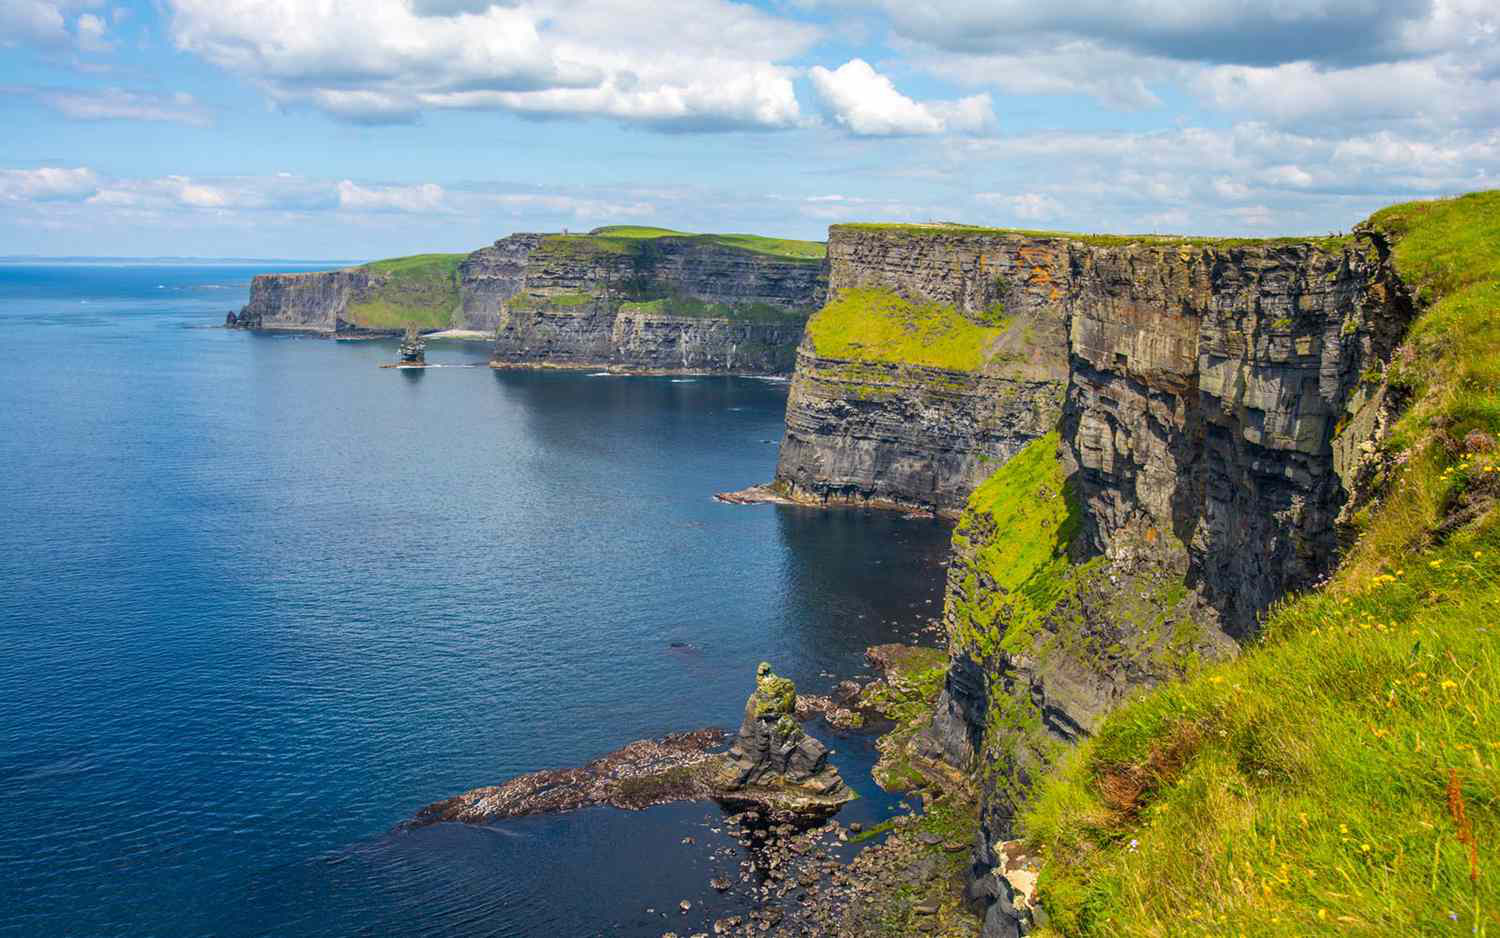

In [112]:
img = Image.open("image_samples/cliffs_of_moher.jpg")
img

## Get RGB colors

In [113]:
# convert RGBA to RGB if necessary
n_dims = np.array(img).shape[-1]
n_dims # RGB -> has 3 channels

3

In [114]:
# Convert RGBA to RGB
if n_dims == 4:
    background = Image.new("RGB", img.size, (255, 255, 255))
    background.paste(img, mask=img.split()[3]) # 3 is the alpha channel
    img = background

In [115]:
r,g,b = np.array(img).reshape(-1,n_dims).T

## Store RGB colors of all pixels to DataFrame

In [116]:
df_rgb = pd.DataFrame({"R": r, "G": g, "B": b}).sample(n=1000)

In [117]:
df_rgb

R    G    B
90373    210  220  230
1087540    9   79  128
1173623  122   96   69
428631    77   65   51
144363   209  223  234
...      ...  ...  ...
1261729    9   61  101
418595    52  137  201
628326    16   31   36
701631    34   34   32
1200184   13   69  116

[1000 rows x 3 columns]

# Clustering

## Set Palette Size

Number of clusters is the palette size.

In [118]:
palette_size = 4

## Train KMeans Model

In [119]:
kmeans_model = KMeans(n_clusters=palette_size, 
                      random_state=0, 
                      init="k-means++",
                      n_init="auto").fit(df_rgb)

## Fetch Cluster Centers

The cluster centers are the palette colours in RGB Format

In [120]:
kmeans_model.cluster_centers_.astype(int).tolist()

[[47, 68, 83], [182, 206, 226], [142, 136, 40], [102, 140, 171]]

In [121]:
palette = kmeans_model.cluster_centers_.astype(int).tolist()

# Palette Visualization & Application

## Sort Palette

In [122]:
# palette.sort(key=lambda rgb: (lambda r, g, b : (r, g, b))(*rgb))
palette.sort(key=lambda rgb: (lambda r, g, b : colorsys.rgb_to_hsv(r, g, b))(*rgb))

In [123]:
palette

[[142, 136, 40], [47, 68, 83], [102, 140, 171], [182, 206, 226]]

## Visualize Palette

In [124]:
img_rgb = np.array([palette], dtype=np.uint8)
fig = px.imshow(img_rgb)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()

## Use Palette in Seaborn

### Convert RGB to Hex Format

In [125]:
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

In [126]:
list_hex = []

for each_rgb_col in palette:
    list_hex.append(rgb_to_hex(each_rgb_col[0], each_rgb_col[1], each_rgb_col[2]))
    
list_hex

['#8e8828', '#2f4453', '#668cab', '#b6cee2']

### Set the Palette

In [127]:
sns.set_palette(list_hex)

In [128]:
sns.color_palette()

[(0.5568627450980392, 0.5333333333333333, 0.1568627450980392),
 (0.1843137254901961, 0.26666666666666666, 0.3254901960784314),
 (0.4, 0.5490196078431373, 0.6705882352941176),
 (0.7137254901960784, 0.807843137254902, 0.8862745098039215)]

### Example

In [129]:
a = list(range(0, 10))
b = np.random.rand(10)

<AxesSubplot:>

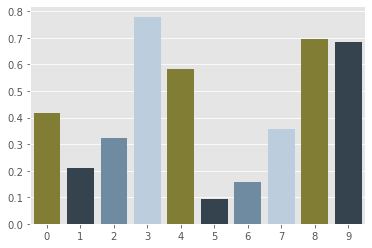

In [130]:
sns.barplot(x=a, 
            y=b,
            palette=sns.color_palette()
           )

## Use Palette in Plotly

In [131]:
import plotly.express as px
df = px.data.gapminder().query("year == 2007")
fig = px.bar(df, y="continent", x="pop", color="continent", orientation="h", hover_name="country",
             color_discrete_sequence=list_hex, # use the list of hex here
             title="Explicit color sequence"
            )

fig.show()

## Use Palette in Matplotlib

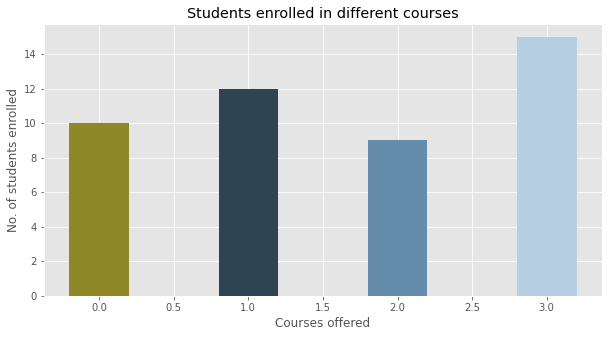

In [132]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar([0, 1, 2, 3], [10, 12, 9, 15], color = list_hex,
        width = 0.4)
 
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.show()

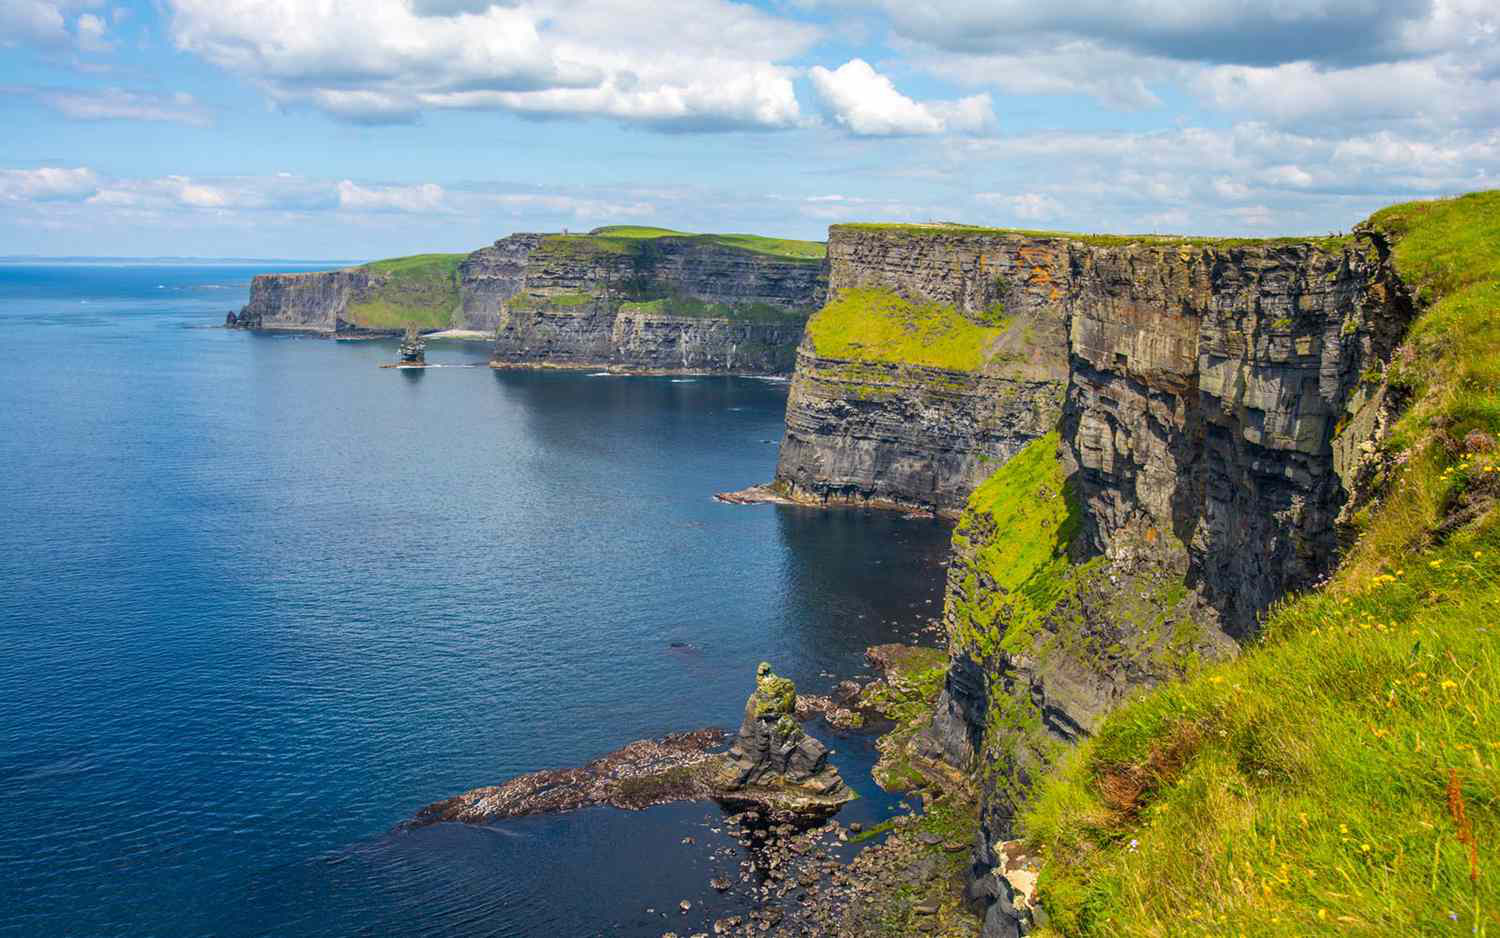

[(0.5568627450980392, 0.5333333333333333, 0.1568627450980392),
 (0.1843137254901961, 0.26666666666666666, 0.3254901960784314),
 (0.4, 0.5490196078431373, 0.6705882352941176),
 (0.7137254901960784, 0.807843137254902, 0.8862745098039215)]

In [133]:
display(img)
sns.color_palette(list_hex)

# Cluster Analysis

In [134]:
clusters = kmeans_model.predict(df_rgb)
df_rgb['n_cluster'] = clusters

In [135]:
df_rgb[df_rgb['n_cluster'] == 0].head()

R   G    B  n_cluster
1087540   9  79  128          0
428631   77  65   51          0
491246   78  96  108          0
970535   26  96  145          0
1072533   0  57  108          0

In [136]:
df_rgb['hex_code'] = df_rgb.apply(lambda x: rgb_to_hex(x[0], x[1], x[2]), axis = 1)

In [137]:
for each_cluster in range(0, palette_size):
    print('Cluster ', each_cluster)
    display(sns.color_palette(list(df_rgb[df_rgb['n_cluster'] == each_cluster]['hex_code'][:10])))

Cluster  0


[(0.03529411764705882, 0.30980392156862746, 0.5019607843137255),
 (0.30196078431372547, 0.2549019607843137, 0.2),
 (0.3058823529411765, 0.3764705882352941, 0.4235294117647059),
 (0.10196078431372549, 0.3764705882352941, 0.5686274509803921),
 (0.0, 0.2235294117647059, 0.4235294117647059),
 (0.11372549019607843, 0.11372549019607843, 0.10588235294117647),
 (0.19215686274509805, 0.32941176470588235, 0.40784313725490196),
 (0.0392156862745098, 0.26666666666666666, 0.41568627450980394),
 (0.3333333333333333, 0.3058823529411765, 0.3764705882352941),
 (0.0, 0.27450980392156865, 0.4666666666666667)]

Cluster  1


[(0.8235294117647058, 0.8627450980392157, 0.9019607843137255),
 (0.8196078431372549, 0.8745098039215686, 0.9176470588235294),
 (0.7176470588235294, 0.807843137254902, 0.8784313725490196),
 (0.6, 0.7686274509803922, 0.9058823529411765),
 (0.5568627450980392, 0.7607843137254902, 0.9176470588235294),
 (0.6705882352941176, 0.8352941176470589, 0.9333333333333333),
 (0.6627450980392157, 0.7450980392156863, 0.8117647058823529),
 (0.788235294117647, 0.8509803921568627, 0.9098039215686274),
 (0.6549019607843137, 0.788235294117647, 0.8980392156862745),
 (0.6627450980392157, 0.7647058823529411, 0.8313725490196079)]

Cluster  2


[(0.47843137254901963, 0.3764705882352941, 0.27058823529411763),
 (0.6627450980392157, 0.5607843137254902, 0.08627450980392157),
 (0.6705882352941176, 0.6509803921568628, 0.01568627450980392),
 (0.4470588235294118, 0.49019607843137253, 0.0),
 (0.44313725490196076, 0.4980392156862745, 0.20392156862745098),
 (0.7411764705882353, 0.7019607843137254, 0.11764705882352941),
 (0.5098039215686274, 0.4980392156862745, 0.09411764705882353),
 (0.5058823529411764, 0.43529411764705883, 0.3803921568627451),
 (0.45098039215686275, 0.2627450980392157, 0.011764705882352941),
 (0.6588235294117647, 0.6901960784313725, 0.043137254901960784)]

Cluster  3


[(0.29411764705882354, 0.4549019607843137, 0.5803921568627451),
 (0.2549019607843137, 0.41568627450980394, 0.5411764705882353),
 (0.2980392156862745, 0.4588235294117647, 0.5843137254901961),
 (0.49019607843137253, 0.6705882352941176, 0.8117647058823529),
 (0.4196078431372549, 0.6235294117647059, 0.7803921568627451),
 (0.39215686274509803, 0.5529411764705883, 0.6784313725490196),
 (0.5215686274509804, 0.6313725490196078, 0.7176470588235294),
 (0.5372549019607843, 0.6470588235294118, 0.7333333333333333),
 (0.4666666666666667, 0.596078431372549, 0.7333333333333333),
 (0.4470588235294118, 0.6274509803921569, 0.7686274509803922)]

# Demo

In [138]:
def generate_palette(img, palette_size):
    n_dims = np.array(img).shape[-1]
    # Convert RGBA to RGB
    if n_dims == 4:
        background = Image.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])  # 3 is the alpha channel
        img = background
    r, g, b = np.array(img).reshape(-1, n_dims).T
    df = pd.DataFrame({"R": r, "G": g, "B": b}).sample(n=1000)
    kmeans_model = KMeans(n_clusters=palette_size,
                          random_state=0,
                          init="k-means++",
                          n_init="auto").fit(df)
    palette = kmeans_model.cluster_centers_.astype(int).tolist()
    palette.sort(key=lambda rgb: (lambda r, g, b: colorsys.rgb_to_hsv(r, g, b))(*rgb))
    list_hex = []
    for each_rgb_col in palette:
        list_hex.append(rgb_to_hex(each_rgb_col[0], each_rgb_col[1], each_rgb_col[2]))
    sns.set_palette(list_hex)
    return sns.color_palette()

In [139]:
img_link = input("Image Link:")

Image Link:https://www.abercrombiekent.co.uk/-/media/abercrombieandkent/images/page-header-images/europe/greece/santorini-and-mykonos/santorini--mykonos0002greecesantorinishutterstock114807193.jpg?w=1920&h=940


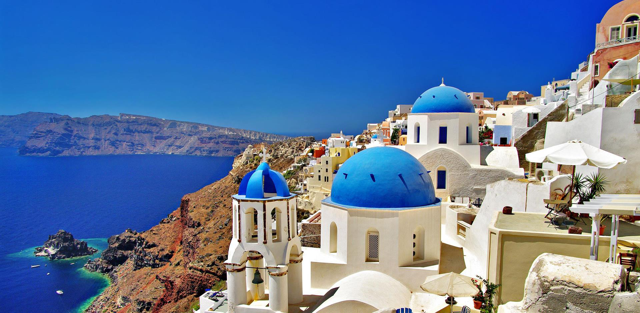

In [140]:
response = requests.get(img_link)
img = Image.open(BytesIO(response.content))
img.resize((round(img.size[0]/3), round(img.size[1]/3))) # resizing to fit here

In [141]:
generate_palette(img, 5)

[(0.17254901960784313, 0.12549019607843137, 0.11372549019607843),
 (0.5647058823529412, 0.47058823529411764, 0.3607843137254902),
 (0.7372549019607844, 0.6901960784313725, 0.615686274509804),
 (0.9176470588235294, 0.9019607843137255, 0.8666666666666667),
 (0.11372549019607843, 0.37254901960784315, 0.7333333333333333)]